In [1]:
#Install Required Libraries:
!pip install tensorflow torch torchvision transformers scikit-learn xgboost lightgbm matplotlib seaborn


In [2]:
#Import Libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
import torch
from torchvision import transforms, models


In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Load the MNIST dataset
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,  # Returns (image, label) pairs
    with_info=True,  # Get metadata about the dataset
)

# Preprocess the data (e.g., normalize pixel values)
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

# Now you can use ds_train and ds_test for training and evaluation

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
import tensorflow_datasets as tfds
# Load Fashion MNIST
(ds_train, ds_test), ds_info = tfds.load(
       'fashion_mnist',
       split=['train', 'test'],
       as_supervised=True,
       with_info=True,
   )
   # ... (Similar preprocessing as MNIST)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.8E2RMG_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.8E2RMG_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


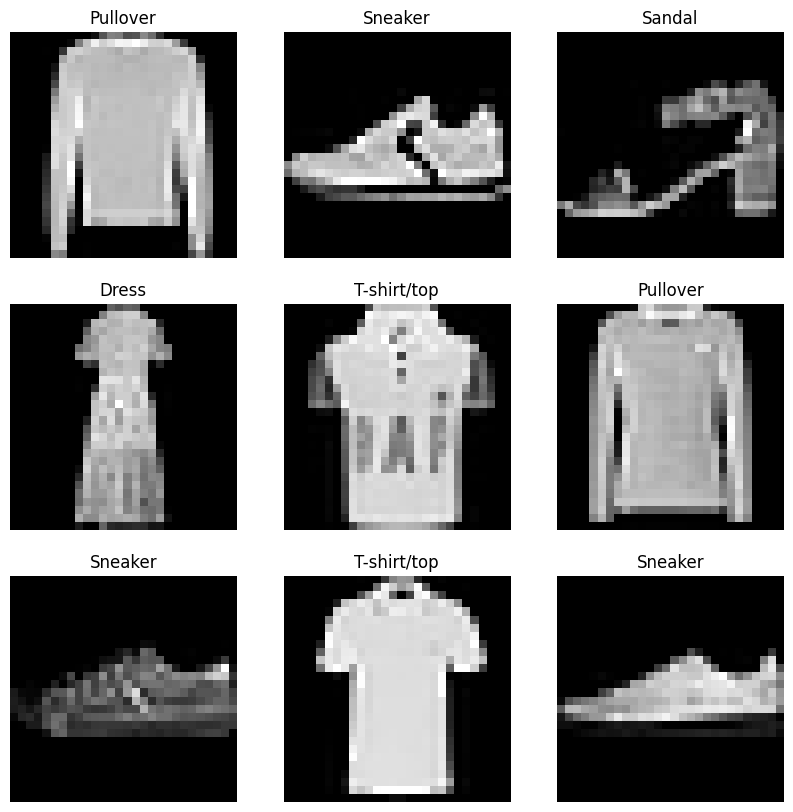

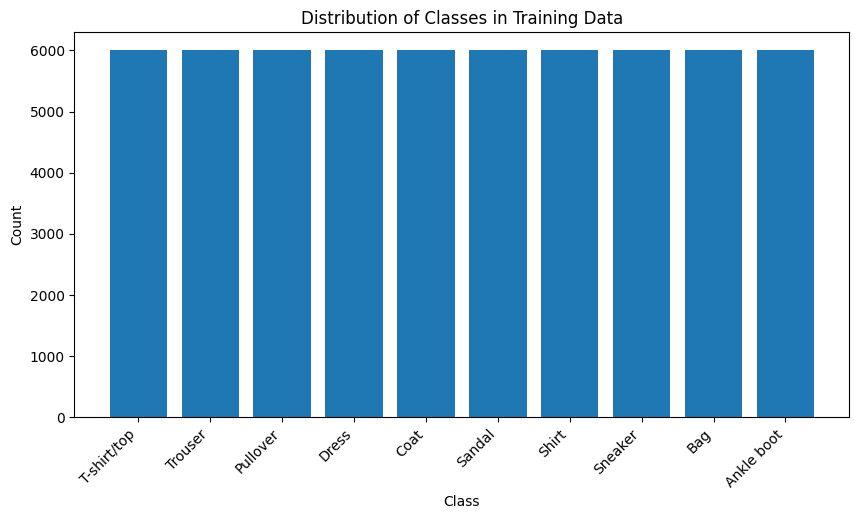

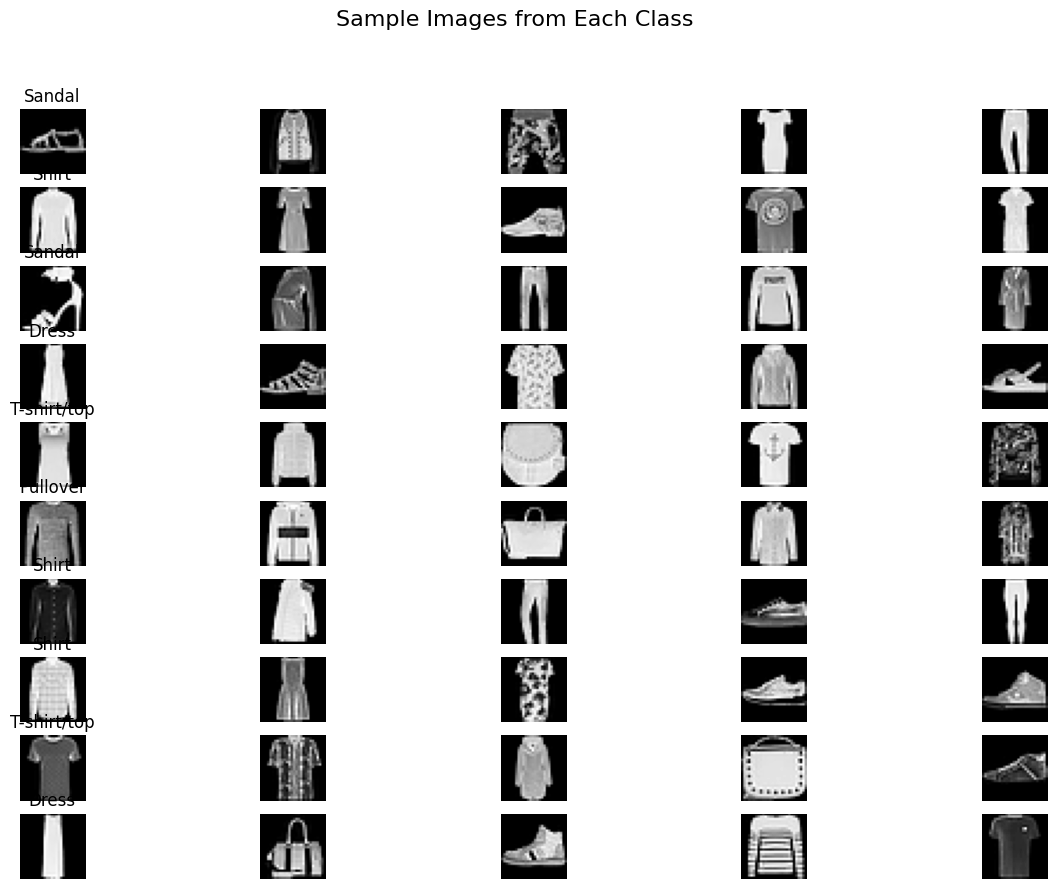

In [5]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load Fashion MNIST
(ds_train, ds_test), ds_info = tfds.load(
       'fashion_mnist',
       split=['train', 'test'],
       as_supervised=True,
       with_info=True,
   )

# Preprocess the data (normalize pixel values)
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

# Class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 1. Show images with labels
plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')  # squeeze to remove channel dim
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
plt.show()

# 2. Distribution of classes
train_labels = np.concatenate([labels.numpy() for _, labels in ds_train])
plt.figure(figsize=(10, 5))
plt.hist(train_labels, bins=np.arange(len(class_names) + 1) - 0.5, rwidth=0.8)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.title('Distribution of Classes in Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# 3. Grid of images from different classes
num_classes = len(class_names)
num_images_per_class = 5

plt.figure(figsize=(15, 10))
for class_id in range(num_classes):
    # Filter dataset for the current class
    class_dataset = ds_train.filter(lambda image, label: tf.reduce_any(tf.equal(label, class_id)))

    for i, (image, label) in enumerate(class_dataset.take(num_images_per_class)):
        ax = plt.subplot(num_classes, num_images_per_class, class_id * num_images_per_class + i + 1)
        # Display a single image from the batch (using index 0) and squeeze out the channel dimension if necessary
        plt.imshow(image[0].numpy().squeeze(), cmap='gray')
        plt.title(class_names[label[0].numpy()]) if i == 0 else plt.title('')  # Title for first image only
        plt.axis("off")
plt.suptitle('Sample Images from Each Class', fontsize=16)
plt.show()

In [6]:
#Stage 1: Simple Models

#Logistic Regression:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Flatten images for Logistic Regression
def flatten_images(dataset):
    images, labels = [], []
    for image, label in dataset.unbatch():
        images.append(image.numpy().flatten())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

# Use ds_train and ds_test instead of train_data and test_data
train_images, train_labels = flatten_images(ds_train) # Changed train_data to ds_train
test_images, test_labels = flatten_images(ds_test) # Changed test_data to ds_test


# Logistic Regression Model
model = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression())])
model.fit(train_images, train_labels)

preds = model.predict(test_images)
print("Accuracy:", accuracy_score(test_labels, preds))

Accuracy: 0.8429


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
#Support Vector Machine (SVM):
svm_model = Pipeline([('scaler', StandardScaler()), ('svm', SVC(kernel='rbf'))])
svm_model.fit(train_images, train_labels)

preds = svm_model.predict(test_images)
print("SVM Accuracy:", accuracy_score(test_labels, preds))


SVM Accuracy: 0.8836


In [8]:
#Decision Tree:
tree_model = DecisionTreeClassifier(max_depth=10)
tree_model.fit(train_images, train_labels)

preds = tree_model.predict(test_images)
print("Decision Tree Accuracy:", accuracy_score(test_labels, preds))


Decision Tree Accuracy: 0.801


In [9]:
#Stage 2: Complex Models 4. Random Forest:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(train_images, train_labels)

preds = rf_model.predict(test_images)
print("Random Forest Accuracy:", accuracy_score(test_labels, preds))


Random Forest Accuracy: 0.8761


In [10]:
#Gradient Boosting (XGBoost):
xgb_model = XGBClassifier()
xgb_model.fit(train_images, train_labels)

preds = xgb_model.predict(test_images)
print("XGBoost Accuracy:", accuracy_score(test_labels, preds))


XGBoost Accuracy: 0.8985


In [11]:
#Deep Neural Network (DNN):
dnn_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

dnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = dnn_model.fit(ds_train, validation_data=ds_test, epochs=10)

# Evaluate the model on the test data
loss, accuracy = dnn_model.evaluate(ds_test, verbose=0)

print(f"DNN Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7351 - loss: 0.7715 - val_accuracy: 0.8476 - val_loss: 0.4245
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8599 - loss: 0.3908 - val_accuracy: 0.8594 - val_loss: 0.3937
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8783 - loss: 0.3400 - val_accuracy: 0.8584 - val_loss: 0.3886
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8810 - loss: 0.3244 - val_accuracy: 0.8708 - val_loss: 0.3626
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8914 - loss: 0.2973 - val_accuracy: 0.8745 - val_loss: 0.3472
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8958 - loss: 0.2814 - val_accuracy: 0.8754 - val_loss: 0.3403
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8980 - loss: 0.2746 - val_accuracy: 0.8822 - val_loss: 0.3319
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9067 - loss: 0.2545 - val_accuracy: 0.

Epoch 1/10


Training: 100%|██████████| 469/469 [00:35<00:00, 13.05batch/s, loss=0.693]


469/469 ━━━━━━━━━━━━━━━━━━ Train Accuracy: 0.7512 - Train Loss: 0.7118 - Val Accuracy: 0.7829 - Val Loss: 0.5834
Epoch 2/10


Training: 100%|██████████| 469/469 [00:34<00:00, 13.45batch/s, loss=0.5]


469/469 ━━━━━━━━━━━━━━━━━━ Train Accuracy: 0.8171 - Train Loss: 0.5100 - Val Accuracy: 0.7803 - Val Loss: 0.6275
Epoch 3/10


Training: 100%|██████████| 469/469 [00:35<00:00, 13.34batch/s, loss=0.392]


469/469 ━━━━━━━━━━━━━━━━━━ Train Accuracy: 0.8417 - Train Loss: 0.4407 - Val Accuracy: 0.8210 - Val Loss: 0.4712
Epoch 4/10


Training: 100%|██████████| 469/469 [00:35<00:00, 13.16batch/s, loss=0.431]


469/469 ━━━━━━━━━━━━━━━━━━ Train Accuracy: 0.8578 - Train Loss: 0.3958 - Val Accuracy: 0.8518 - Val Loss: 0.4065
Epoch 5/10


Training: 100%|██████████| 469/469 [00:35<00:00, 13.38batch/s, loss=0.589]


469/469 ━━━━━━━━━━━━━━━━━━ Train Accuracy: 0.8703 - Train Loss: 0.3632 - Val Accuracy: 0.8500 - Val Loss: 0.4256
Epoch 6/10


Training: 100%|██████████| 469/469 [00:35<00:00, 13.30batch/s, loss=0.286]


469/469 ━━━━━━━━━━━━━━━━━━ Train Accuracy: 0.8789 - Train Loss: 0.3371 - Val Accuracy: 0.8527 - Val Loss: 0.4237
Epoch 7/10


Training: 100%|██████████| 469/469 [00:35<00:00, 13.21batch/s, loss=0.431]


469/469 ━━━━━━━━━━━━━━━━━━ Train Accuracy: 0.8885 - Train Loss: 0.3094 - Val Accuracy: 0.8700 - Val Loss: 0.3740
Epoch 8/10


Training: 100%|██████████| 469/469 [00:35<00:00, 13.36batch/s, loss=0.295]


469/469 ━━━━━━━━━━━━━━━━━━ Train Accuracy: 0.8952 - Train Loss: 0.2903 - Val Accuracy: 0.8661 - Val Loss: 0.4101
Epoch 9/10


Training: 100%|██████████| 469/469 [00:35<00:00, 13.28batch/s, loss=0.298]


469/469 ━━━━━━━━━━━━━━━━━━ Train Accuracy: 0.9037 - Train Loss: 0.2662 - Val Accuracy: 0.8656 - Val Loss: 0.3894
Epoch 10/10


Training: 100%|██████████| 469/469 [00:35<00:00, 13.38batch/s, loss=0.284]


469/469 ━━━━━━━━━━━━━━━━━━ Train Accuracy: 0.9114 - Train Loss: 0.2431 - Val Accuracy: 0.8758 - Val Loss: 0.3806


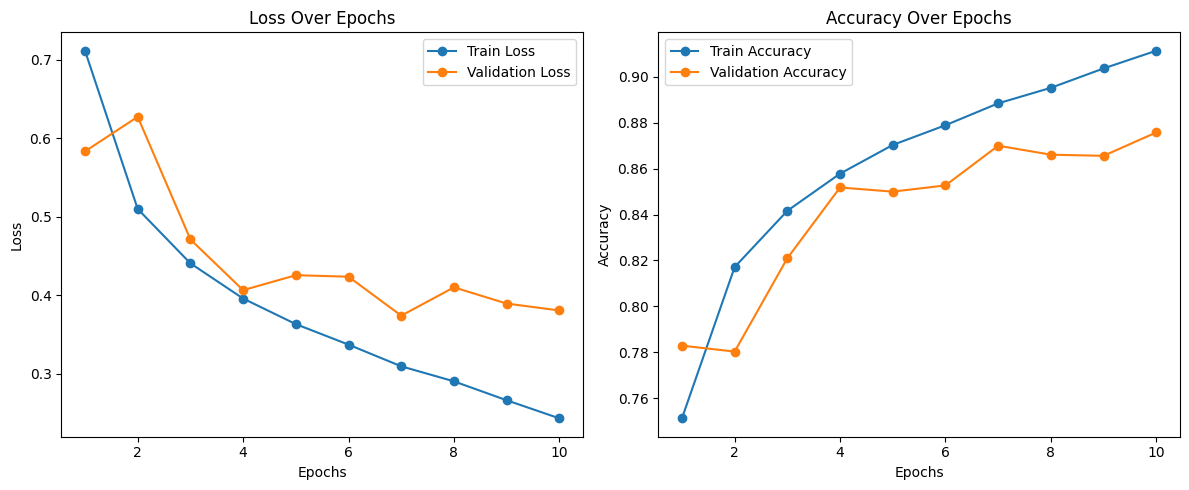

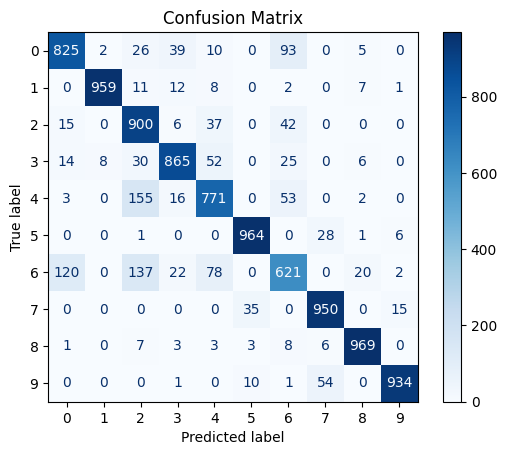

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.82      0.83      1000
     Trouser       0.99      0.96      0.97      1000
    Pullover       0.71      0.90      0.79      1000
       Dress       0.90      0.86      0.88      1000
        Coat       0.80      0.77      0.79      1000
      Sandal       0.95      0.96      0.96      1000
       Shirt       0.73      0.62      0.67      1000
     Sneaker       0.92      0.95      0.93      1000
         Bag       0.96      0.97      0.96      1000
  Ankle boot       0.97      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [39]:
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Load Fashion MNIST
(ds_train, ds_test), ds_info = tfds.load(
    'fashion_mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

# Preprocess the data (normalize pixel values)
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

# Data Augmentation
augmentations = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def augment_data(image, label):
    image = augmentations(image)
    return image, label

ds_train_augmented = ds_train.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

# Modify ResNet18 for grayscale input and feature extraction
cnn_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
cnn_model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
cnn_model.fc = torch.nn.Identity()  # Remove last layer

# Define Improved CNN+RNN Model
class CNN_RNN_Model_Improved(torch.nn.Module):
    def __init__(self, cnn, hidden_size, num_classes):
        super().__init__()
        self.cnn = cnn
        self.rnn = torch.nn.LSTM(512, hidden_size, batch_first=True)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.batch_norm = torch.nn.BatchNorm1d(hidden_size)
        self.fc = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        features = self.cnn(x)
        out, _ = self.rnn(features.unsqueeze(1))
        out = self.dropout(out[:, -1, :])
        out = self.batch_norm(out)
        return self.fc(out)

# Instantiate the improved model
improved_model = CNN_RNN_Model_Improved(cnn_model, 128, ds_info.features['label'].num_classes)

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
improved_model.to(device)

# Create PyTorch DataLoader
def create_pytorch_dataloader(tf_dataset):
    images, labels = [], []
    for image, label in tf_dataset.unbatch():
        images.append(image.numpy())
        labels.append(label.numpy())
    images = np.array(images)
    labels = np.array(labels)
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(images).float(), torch.from_numpy(labels).long())
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
    return dataloader

train_dataloader = create_pytorch_dataloader(ds_train_augmented)
test_dataloader = create_pytorch_dataloader(ds_test)

# Define optimizer, loss, and scheduler
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(improved_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Training and Validation Metrics Storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 10  # Adjust as needed
train_steps = len(train_dataloader)
test_steps = len(test_dataloader)

for epoch in range(num_epochs):
    improved_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    print(f"Epoch {epoch + 1}/{num_epochs}")
    with tqdm(total=train_steps, desc="Training", unit="batch") as pbar:
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            images = images.permute(0, 3, 1, 2)  # Convert NHWC to NCHW format for PyTorch

            optimizer.zero_grad()
            outputs = improved_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            pbar.set_postfix(loss=loss.item())
            pbar.update(1)

    train_accuracy = correct_train / total_train
    train_loss = running_loss / train_steps

    # Validation evaluation
    improved_model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            images = images.permute(0, 3, 1, 2)

            outputs = improved_model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = correct_val / total_val
    val_loss = running_val_loss / test_steps

    # Append metrics for visualization
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"{train_steps}/{train_steps} ━━━━━━━━━━━━━━━━━━ Train Accuracy: {train_accuracy:.4f} - "
          f"Train Loss: {train_loss:.4f} - Val Accuracy: {val_accuracy:.4f} - Val Loss: {val_loss:.4f}")

# Visualization of Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix and Classification Report
all_preds = []
all_labels = []

improved_model.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        images = images.permute(0, 3, 1, 2)
        outputs = improved_model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=range(ds_info.features['label'].num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=ds_info.features['label'].names))


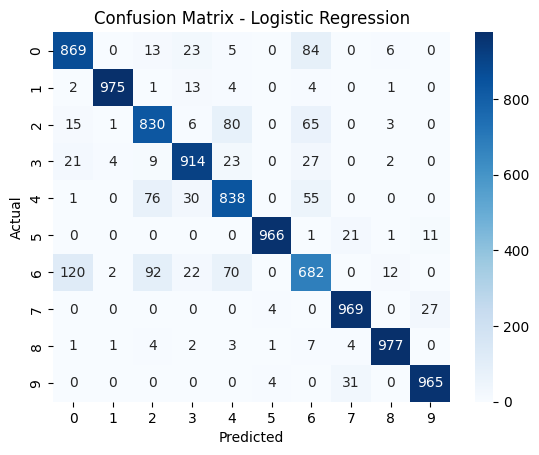

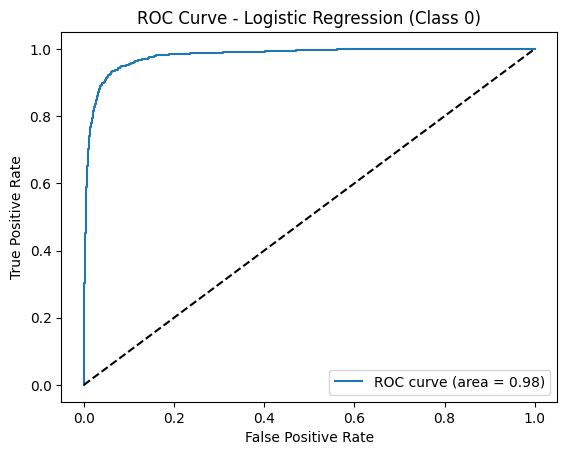

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.83      0.82      1000
           3       0.90      0.91      0.91      1000
           4       0.82      0.84      0.83      1000
           5       0.99      0.97      0.98      1000
           6       0.74      0.68      0.71      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [14]:
#Visualization Techniques 1. Logistic Regression
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

# Choose a specific class as the positive class (e.g., class 0: 'T-shirt/top')
pos_label = 0  # Replace with desired positive class

# Predict probabilities for the positive class
y_probs = model.predict_proba(test_images)[:, pos_label]

# Confusion Matrix
cm = confusion_matrix(test_labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC Curve (for the chosen positive class)
fpr, tpr, _ = roc_curve(test_labels, y_probs, pos_label=pos_label)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - Logistic Regression (Class {pos_label})')
plt.legend(loc="lower right")
plt.show()

# Classification Report
print(classification_report(test_labels, preds))

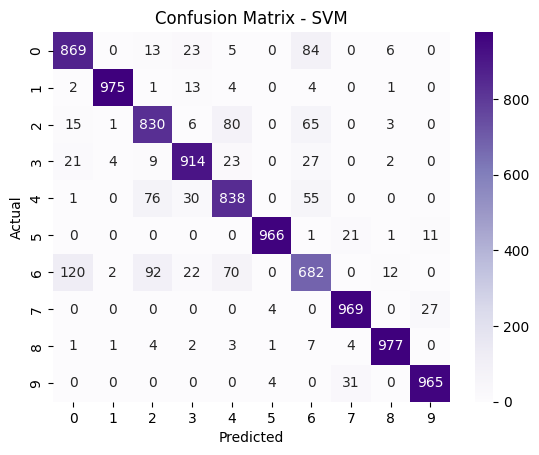

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1000
           1       0.99      0.97      0.98      1000
           2       0.81      0.83      0.82      1000
           3       0.90      0.91      0.91      1000
           4       0.82      0.84      0.83      1000
           5       0.99      0.97      0.98      1000
           6       0.74      0.68      0.71      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [15]:
#Support Vector Machine (SVM)
# Confusion Matrix
cm = confusion_matrix(test_labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix - SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print(classification_report(test_labels, preds))


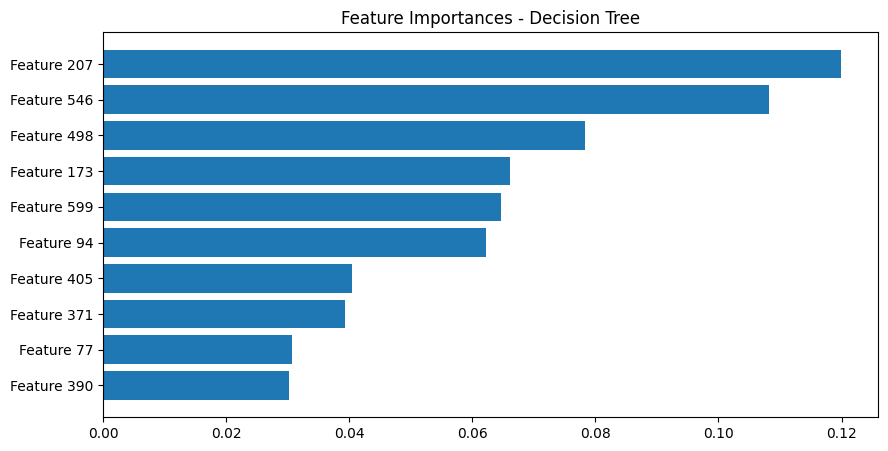

In [16]:
#Decision Tree
# Feature Importance Visualization
importances = tree_model.feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10, 5))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
plt.title('Feature Importances - Decision Tree')
plt.show()


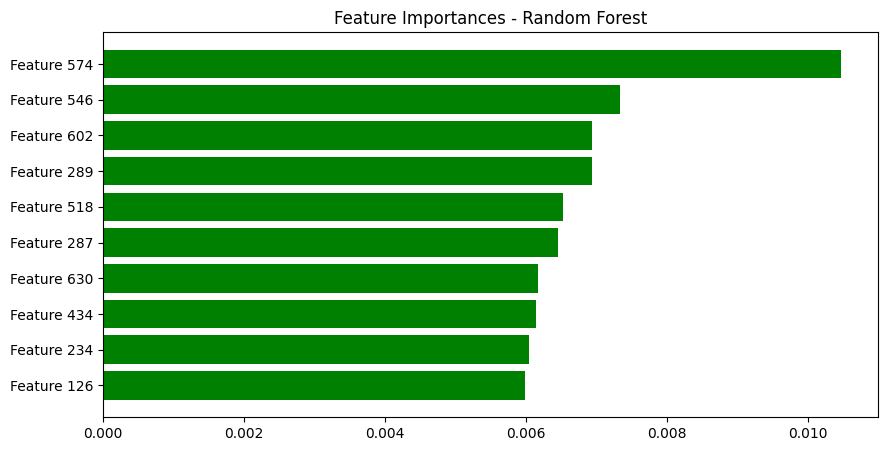

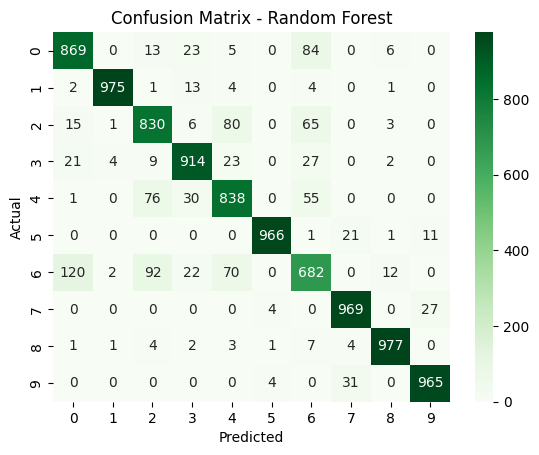

In [17]:
#Random Forest
# Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10, 5))
plt.barh(range(len(indices)), importances[indices], align='center', color='green')
plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
plt.title('Feature Importances - Random Forest')
plt.show()

# Confusion Matrix
cm = confusion_matrix(test_labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


[0]	validation_0-merror:0.16725	validation_0-mlogloss:1.38594	validation_1-merror:0.19690	validation_1-mlogloss:1.41926
[1]	validation_0-merror:0.14540	validation_0-mlogloss:1.08137	validation_1-merror:0.17520	validation_1-mlogloss:1.13055
[2]	validation_0-merror:0.13483	validation_0-mlogloss:0.88334	validation_1-merror:0.16770	validation_1-mlogloss:0.94356
[3]	validation_0-merror:0.12608	validation_0-mlogloss:0.74225	validation_1-merror:0.16290	validation_1-mlogloss:0.81069
[4]	validation_0-merror:0.12003	validation_0-mlogloss:0.63816	validation_1-merror:0.16030	validation_1-mlogloss:0.71426
[5]	validation_0-merror:0.11593	validation_0-mlogloss:0.55917	validation_1-merror:0.15680	validation_1-mlogloss:0.64182
[6]	validation_0-merror:0.11195	validation_0-mlogloss:0.49906	validation_1-merror:0.15440	validation_1-mlogloss:0.58735
[7]	validation_0-merror:0.10772	validation_0-mlogloss:0.45032	validation_1-merror:0.15100	validation_1-mlogloss:0.54405
[8]	validation_0-merror:0.10328	validati

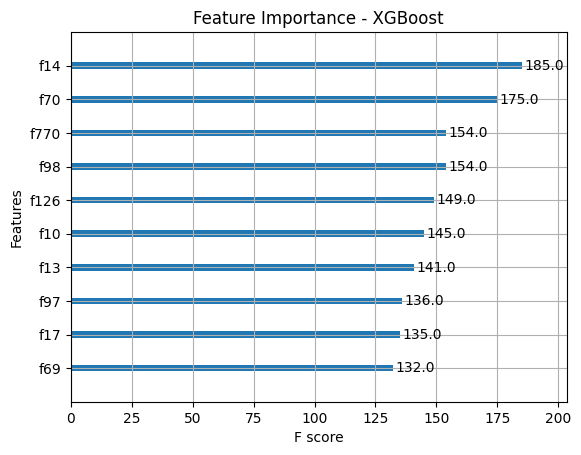

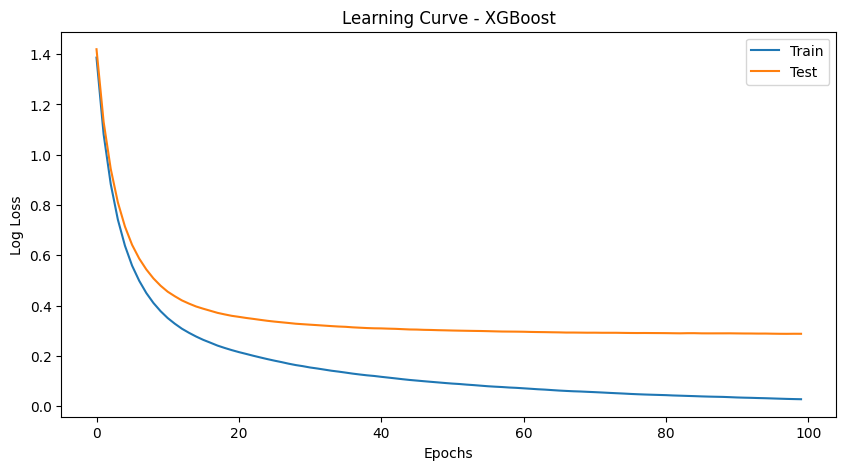

In [18]:
#Gradient Boosting (XGBoost)
# Feature Importance Plot
from xgboost import plot_importance  # Import the plot_importance function

# Ensure xgb_model is defined and trained before this cell
xgb_model = XGBClassifier(eval_metric=["merror", "mlogloss"]) # Define eval_metric here during initialization

# Specify eval_set during training
eval_set = [(train_images, train_labels), (test_images, test_labels)]  # Use your test data for evaluation
xgb_model.fit(train_images, train_labels, eval_set=eval_set, verbose=True) # Train with eval_set, removed eval_metric from here


plot_importance(xgb_model, importance_type='weight', max_num_features=10) # Call using plot_importance directly
plt.title('Feature Importance - XGBoost')
plt.show()

# Learning Curve
results = xgb_model.evals_result()
epochs = len(results['validation_0']['mlogloss'])

plt.figure(figsize=(10, 5))
plt.plot(range(epochs), results['validation_0']['mlogloss'], label='Train')
plt.plot(range(epochs), results['validation_1']['mlogloss'], label='Test')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Learning Curve - XGBoost')
plt.legend()
plt.show()

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9095 - loss: 0.2406 - val_accuracy: 0.8846 - val_loss: 0.3241
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9151 - loss: 0.2240 - val_accuracy: 0.8839 - val_loss: 0.3359
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9162 - loss: 0.2206 - val_accuracy: 0.8883 - val_loss: 0.3183
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9202 - loss: 0.2116 - val_accuracy: 0.8849 - val_loss: 0.3355
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9223 - loss: 0.2054 - val_accuracy: 0.8865 - val_loss: 0.3354
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9273 - loss: 0.1950 - val_accuracy: 0.8825 - val_loss: 0.3293
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9263 - loss: 0.1949 - val_accuracy: 0.8863 - val_loss: 0.3407
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9302 - loss: 0.1839 - val_accuracy: 0

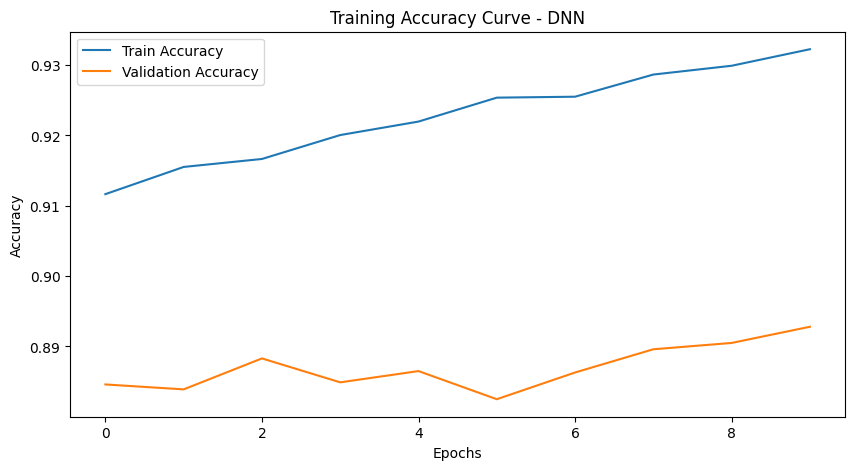

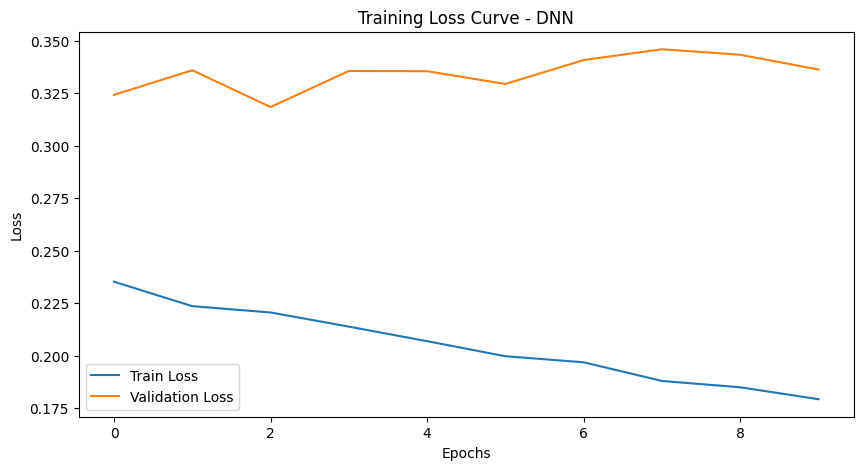

In [19]:
#Deep Neural Network (DNN)
# Accuracy and Loss Curves
history = dnn_model.fit(ds_train, validation_data=ds_test, epochs=10)

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve - DNN')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve - DNN')
plt.legend()
plt.show()


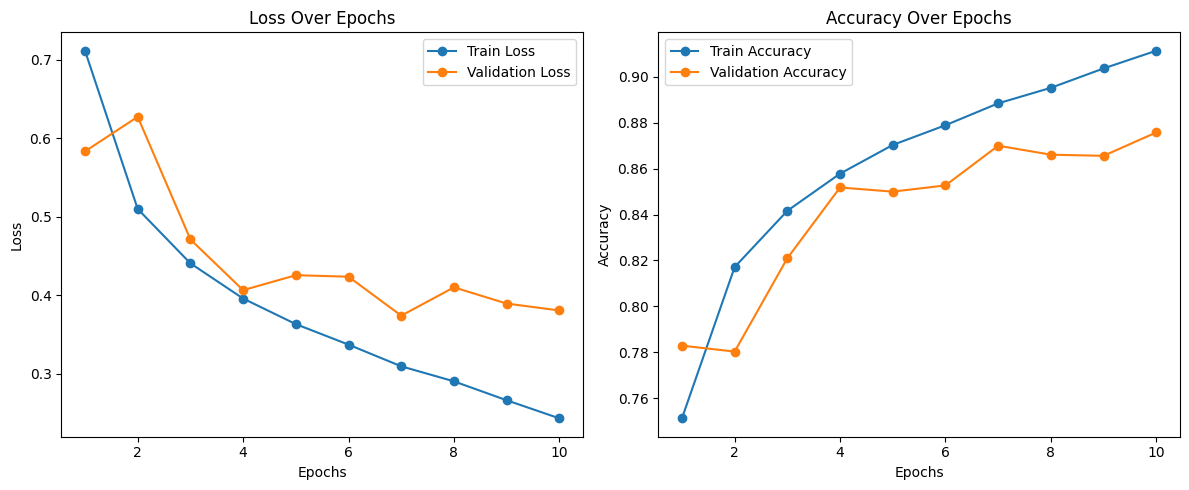

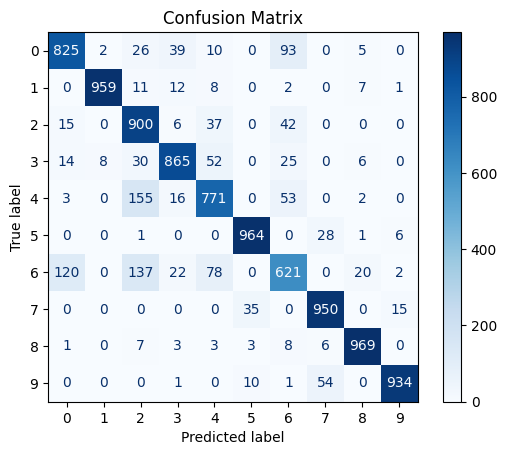

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.82      0.83      1000
     Trouser       0.99      0.96      0.97      1000
    Pullover       0.71      0.90      0.79      1000
       Dress       0.90      0.86      0.88      1000
        Coat       0.80      0.77      0.79      1000
      Sandal       0.95      0.96      0.96      1000
       Shirt       0.73      0.62      0.67      1000
     Sneaker       0.92      0.95      0.93      1000
         Bag       0.96      0.97      0.96      1000
  Ankle boot       0.97      0.93      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Visualization of Loss and Accuracy
plt.figure(figsize=(12, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix and Classification Report
all_preds = []
all_labels = []

improved_model.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        images = images.permute(0, 3, 1, 2)
        outputs = improved_model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=range(ds_info.features['label'].num_classes))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=ds_info.features['label'].names))


Device set to use cuda:0


Accuracy: 0.8331


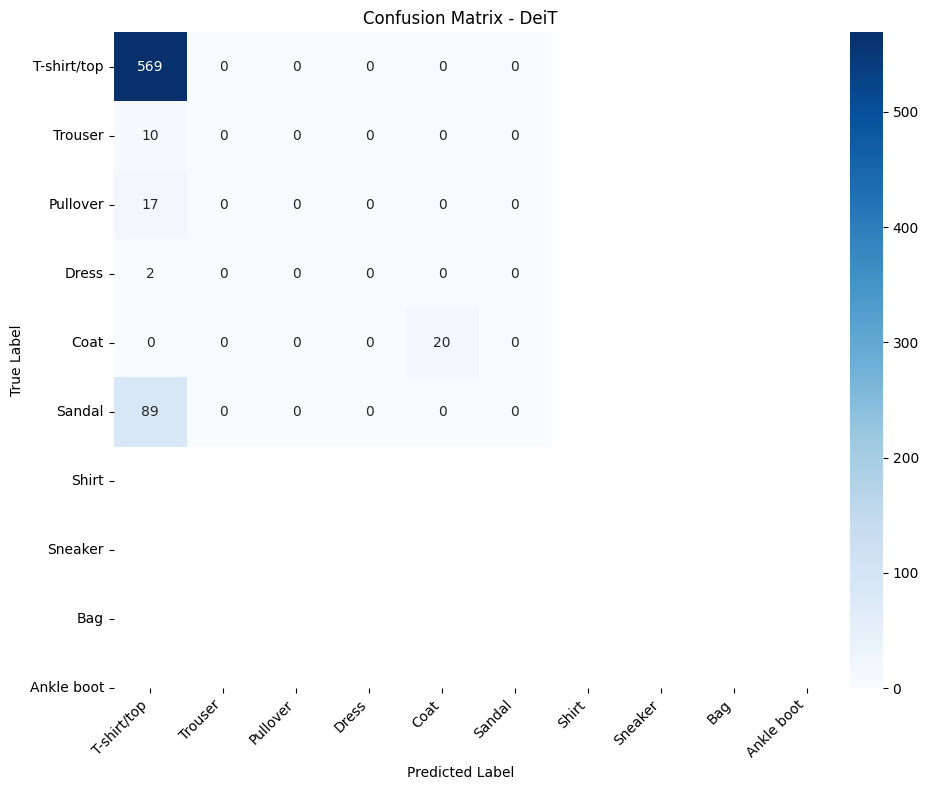

In [27]:
from PIL import Image
import numpy as np
from transformers import pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Load Pre-trained Transformer (DeiT)
model = pipeline('image-classification', model='facebook/deit-base-distilled-patch16-224')

# Function to predict labels for all images in the dataset
def predict_labels_all(dataset):
    all_predicted_labels = []
    all_true_labels = []

    # Extract all images and labels from the dataset
    images, labels = [], []
    for image, label in dataset.unbatch():  # Iterate over individual elements
        images.append(image.numpy())
        labels.append(label.numpy())
    images = np.array(images)
    labels = np.array(labels)

    # Convert images to PIL format and resize
    pil_images = [Image.fromarray(np.uint8(image * 255)[:,:,0]).resize((224, 224)) for image in images]

    # Predict labels for all images using the pipeline
    results = model(pil_images)
    predicted_labels = [result[0]['label'] for result in results]

    return predicted_labels, labels

# Get predictions for the test dataset
all_predicted_labels, all_true_labels = predict_labels_all(ds_test)

# Map predicted labels to Fashion MNIST class indices
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Define mapping from DeiT labels to Fashion MNIST labels
deit_to_fashion_mnist = {
    'jersey, T-shirt, tee shirt': 'T-shirt/top',
    'trousers, pants, slacks': 'Trouser',
    'pullover, jumper': 'Pullover',
    'dress, frock': 'Dress',
    'coat': 'Coat',
    'sandal': 'Sandal',  # DeiT might predict 'sandal' directly
    'shirt, blouse': 'Shirt',
    'sneaker, tennis shoe': 'Sneaker',
    'handbag, handbag, pocketbook, purse': 'Bag',
    'boot': 'Ankle boot', # DeiT might predict 'boot' or 'ankle boot'
}

# Convert predicted labels to numerical indices using the mapping
# Convert predicted labels to numerical indices using the mapping
# If the predicted label is not in the mapping, assign -1
all_predicted_labels_numeric = [class_names.index(deit_to_fashion_mnist.get(label)) if deit_to_fashion_mnist.get(label) in class_names else -1
                                 for label in all_predicted_labels]

# Filter out samples with unknown predictions (label -1)
valid_indices = [i for i, label in enumerate(all_predicted_labels_numeric) if label != -1]
all_predicted_labels_numeric = [all_predicted_labels_numeric[i] for i in valid_indices]
all_true_labels = [all_true_labels[i] for i in valid_indices]


# Calculate accuracy
accuracy = accuracy_score(all_true_labels, all_predicted_labels_numeric)
print(f"Accuracy: {accuracy:.4f}")


# Plot confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels_numeric)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - DeiT')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)  # Keep y-axis labels vertical
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

<ipython-input-28-63786b4e678a>:30: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 69ms/step - accuracy: 0.7289 - loss: 0.8086 - val_accuracy: 0.1738 - val_loss: 10.1795
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8769 - loss: 0.3434 - val_accuracy: 0.2521 - val_loss: 9.4314
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9026 - loss: 0.2729 - val_accuracy: 0.4902 - val_loss: 5.0477
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9169 - loss: 0.2327 - val_accuracy: 0.7908 - val_loss: 0.7365
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9231 - loss: 0.2156 - val_accuracy: 0.8886 - val_loss: 0.3786


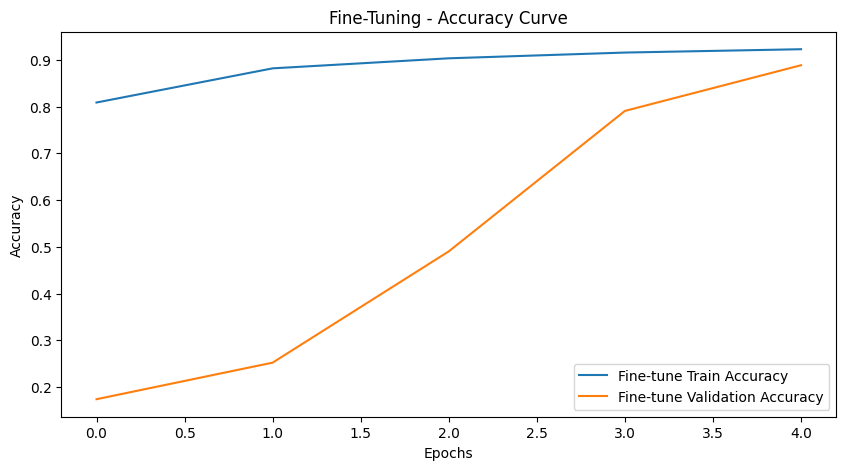

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step


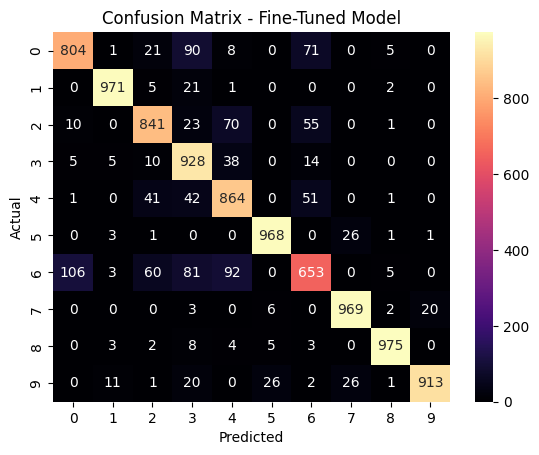

In [28]:
#Pretrained + Fine-Tuned Models

# Fine-tune a pre-trained model (example using MobileNetV2)
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Resize images to the minimum required size for MobileNetV2 (32x32)
IMG_SIZE = 32  # Set the target size

def resize_image(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

ds_train_resized = ds_train.map(resize_image)
ds_test_resized = ds_test.map(resize_image)

# Convert the dataset to have 3 channels (for MobileNetV2)
def to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

ds_train_rgb = ds_train_resized.map(to_rgb)
ds_test_rgb = ds_test_resized.map(to_rgb)


# Load pre-trained MobileNetV2 (without the classification head)
# Use the target input shape (IMG_SIZE, IMG_SIZE, 3)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add a classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# Create the fine-tuned model
fine_tuned_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers (optional)
# for layer in base_model.layers:
#     layer.trainable = False

# Compile the model
fine_tuned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the fine-tuned model and store the history
fine_tune_history = fine_tuned_model.fit(ds_train_rgb, validation_data=ds_test_rgb, epochs=5)  # Adjust epochs as needed


# Fine-Tuned Learning Curves
plt.figure(figsize=(10, 5))

# Check if 'accuracy' key exists in fine_tune_history.history
if 'accuracy' in fine_tune_history.history:
    plt.plot(fine_tune_history.history['accuracy'], label='Fine-tune Train Accuracy')
else:
    print("Warning: 'accuracy' key not found in fine_tune_history.history")

# Check if 'val_accuracy' key exists in fine_tune_history.history
if 'val_accuracy' in fine_tune_history.history:
    plt.plot(fine_tune_history.history['val_accuracy'], label='Fine-tune Validation Accuracy')
else:
    print("Warning: 'val_accuracy' key not found in fine_tune_history.history")

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Fine-Tuning - Accuracy Curve')
plt.legend()
plt.show()

# Fine-Tuned Confusion Matrix
# Get predictions from the fine-tuned model
preds = fine_tuned_model.predict(ds_test_rgb)
preds = np.argmax(preds, axis=1) # Get the class with the highest probability

# Get true labels from the test dataset
true_labels = []
for _, labels in ds_test:
    true_labels.extend(labels.numpy())

cm = confusion_matrix(true_labels, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
plt.title('Confusion Matrix - Fine-Tuned Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [33]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Assuming you already have your Fashion MNIST dataset loaded as 'ds_train' and 'ds_test'

# Preprocessing: Resize and convert to RGB
IMG_SIZE = 32

def resize_image(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

def to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

ds_train_resized = ds_train.map(resize_image)
ds_test_resized = ds_test.map(resize_image)

ds_train_rgb = ds_train_resized.map(to_rgb)
ds_test_rgb = ds_test_resized.map(to_rgb)

# Load pre-trained MobileNetV2 (without the classification head)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Add a classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# Create the fine-tuned model
fine_tuned_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
fine_tuned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the fine-tuned model (you might need to adjust epochs and other parameters)
fine_tuned_model.fit(ds_train_rgb, validation_data=ds_test_rgb, epochs=5)

# Evaluate the fine-tuned model and print the accuracy
_, accuracy = fine_tuned_model.evaluate(ds_test_rgb, verbose=0)
print(f"Fine-Tuned MobileNetV2 Accuracy: {accuracy:.4f}")

<ipython-input-33-cf30c5972411>:26: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 87s 62ms/step - accuracy: 0.7516 - loss: 0.7427 - val_accuracy: 0.3618 - val_loss: 4.3754
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.8963 - loss: 0.2946 - val_accuracy: 0.4022 - val_loss: 5.5205
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9164 - loss: 0.2431 - val_accuracy: 0.4882 - val_loss: 3.8361
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9223 - loss: 0.2167 - val_accuracy: 0.6940 - val_loss: 2.0857
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.9289 - loss: 0.1991 - val_accuracy: 0.8785 - val_loss: 0.4479
Fine-Tuned MobileNetV2 Accuracy: 0.8785
